In [1]:
!pip install transformers

In [2]:
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 31.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.7/596.7 kB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.7 MB/s eta 0:00:00


In [3]:
!pip install -U git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-4rccu767
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-4rccu767
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit e5d3db20e9c2ddb76f88642409e527239943c983
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.3.3-py3-none-any.whl size=106725 sha256=1043696589a113a745aebba2eacb52982f48f51ca1b142dc2b28acd83072c9a4
  Stored in directory: /tmp/pip-ephem-wheel-cache-t8hbx3n4/wheels/1a/49/5f/858bc2741660e381e83f1d8b297edc4d9f0561f29becaee577
  Created wheel for efficientnet-pyt

In [4]:
import os
import cv2
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import models
from datasets import load_metric
from torchmetrics.functional import dice
import torch.optim as optim
import lightning as pl

from transformers import SegformerForSemanticSegmentation
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import KFold
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

### Utils

In [50]:
# RLE 디코딩 함수
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

#RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

### Custom Dataset

In [7]:
class SatelliteDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None, infer=False):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform
        self.infer = infer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_filename = self.data.iloc[idx, 1].lstrip('.')
        img_path = self.image_dir + img_filename
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
                
            sample = {'pixel_values': image}
            
            return sample

        mask_rle = self.data.iloc[idx, 2]
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        mask = torch.unsqueeze(mask, dim=0)
    
        sample = {'pixel_values': image, 'labels': mask}
        
        return sample

### DataLoader

In [8]:
transform = A.Compose(
    [   
        A.Resize(224, 224),
        A.Normalize(),
        ToTensorV2()
    ]
)

**Sampler 추가 필요**

In [9]:
# def get_class_weights(dataframe):
#     # calculate class and sample weights
#     dataframe['have_building'] = dataframe['labels'].apply(lambda x: True if 1 in x else False)
#     class_counts = dataframe['have_building'].value_counts()
#     class_weights = 1 / class_counts
#     sample_weights = [class_weights[i] for i in dataframe['have_building'].values]
#     return sample_weights

In [10]:
# from torch.utils.data import WeightedRandomSampler

# def create_sampler(mode, data):
#     if mode == 'train':
#         sample_w = get_class_weights(data)
#         return WeightedRandomSampler(weights=sample_w,num_samples=len(data))
#     elif mode=='val':
#         sample_w = get_class_weights(data)
#         return WeightedRandomSampler(weights=sample_w,num_samples=len(data))
#     else:
#         return None

In [11]:
dataset = SatelliteDataset(csv_file='/kaggle/input/dacon-building-data/train.csv', image_dir='/kaggle/input/dacon-building-data', transform=transform)
#train_sampler = create_sampler('train', dataset)
#dataloader = DataLoader(dataset, batch_size=16, shuffle=True, sampler=train_sampler, num_workers=2)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2)

In [13]:
s = next(iter(test_dataloader))
ash = s['pixel_values']
print(ash.shape)

torch.Size([16, 3, 224, 224])


In [14]:
s = next(iter(dataloader))
ash = s['pixel_values']
mask = s['labels']
print(ash.shape) 
print(mask.shape)
print(mask[0])

torch.Size([16, 3, 224, 224])
torch.Size([16, 1, 224, 224])
tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)


In [15]:
mask_1 = torch.squeeze(s['labels']).long()
mask_2 = nn.functional.one_hot(mask_1, num_classes=2).permute(0, 3, 1, 2)
mask_3 = mask_1.unsqueeze(1)
print(mask_1.shape)
print(mask_2.shape)
print(mask_3.shape)
print(mask_2[0])

torch.Size([16, 224, 224])
torch.Size([16, 2, 224, 224])
torch.Size([16, 1, 224, 224])
tensor([[[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])


Text(0.5, 1.0, 'mask on false color image')

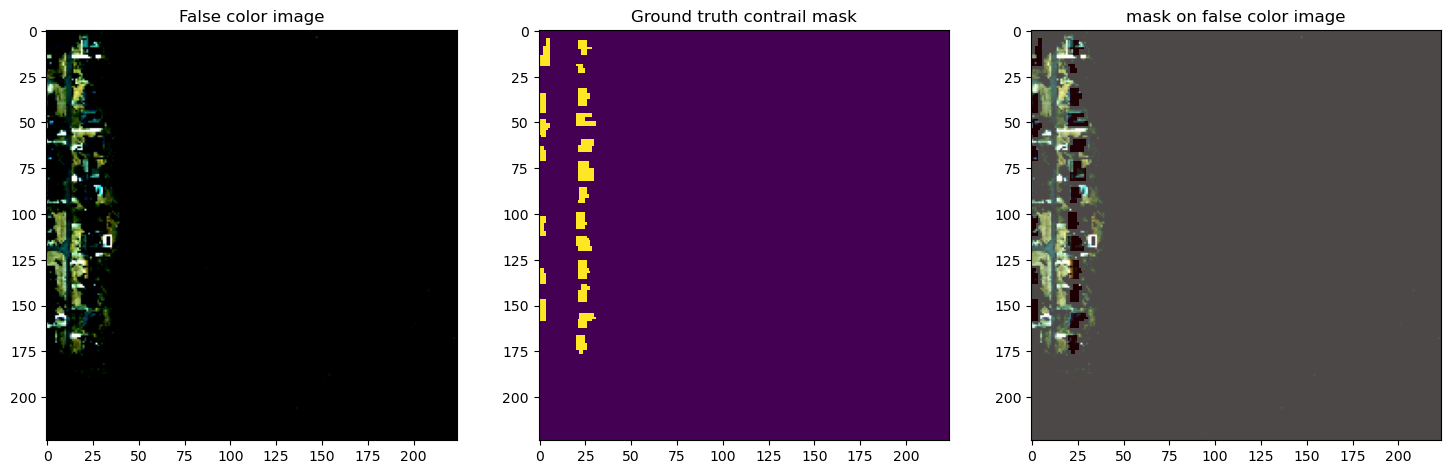

In [16]:
import matplotlib.pyplot as plt

img = ash[2, :, :, :]
mask_show = mask[2, :, :, :]
img = img.numpy().transpose(1, 2, 0)
mask_show = mask_show.numpy().transpose(1, 2, 0)

plt.figure(figsize=(18, 6))
ax = plt.subplot(1, 3, 1)
ax.imshow(img)
ax.set_title('False color image')

ax = plt.subplot(1, 3, 2)
ax.imshow(mask_show, interpolation='none')
ax.set_title('Ground truth contrail mask')

ax = plt.subplot(1, 3, 3)
ax.imshow(img)
ax.imshow(mask_show, cmap='Reds', alpha=0.3, interpolation='none')
ax.set_title('mask on false color image')

### Build Model

### loss_fn

In [17]:
ALPHA = 0.5
BETA = 0.5
GAMMA = 1

class FocalTverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalTverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=0.5, alpha=ALPHA, beta=BETA, gamma=GAMMA):
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
    
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
        
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = (1 - Tversky)**gamma
        return FocalTversky

In [18]:
import segmentation_models_pytorch as smp

In [19]:
class SegFormerModel(pl.LightningModule):
    def __init__(self, train_dataloader=None, val_dataloader=None, test_dataloader=None, metrics_interval=10, model=None):
        super(SegFormerModel, self).__init__()
        self.metrics_interval = metrics_interval
        self.train_dl = train_dataloader
        self.val_dl = val_dataloader
        self.test_dl = test_dataloader
        self.num_classes = 2
        self.model = model or get_initial_model(self.num_classes)
        self.loss_module = smp.losses.DiceLoss(mode="binary", smooth=1.0, from_logits=True)
        self.train_step_ious= []
        self.validation_step_ious = []
        self.validation_step_outputs = []
        self.test_step_outputs = []
        self.save_hyperparameters()
        
    def forward(self, images, masks=None):
        outputs = self.model(pixel_values=images)
        return outputs
    
    def training_step(self, batch, batch_idx):
        masks = torch.squeeze(batch['labels']).long().to(device)
        masks = nn.functional.one_hot(masks, num_classes=self.num_classes).permute(0, 3, 1, 2).contiguous().to(device)
        images = batch['pixel_values'].float().to(device)
            
        outputs = self.model(pixel_values=images, return_dict=True)
        
        upsampled_logits = nn.functional.interpolate(
            outputs.logits, 
            size=masks.shape[-2:], 
            mode="bilinear", 
            align_corners=False
        ).contiguous().to(device)
        
    # predicted = upsampled_logits.argmax(dim=1)
        loss = self.loss_module(upsampled_logits, masks)
        tp, fp, fn, tn = smp.metrics.get_stats((upsampled_logits.sigmoid()>0.5).long(), masks.long(), mode='binary')
        iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        self.train_step_ious.append(iou)
    
        if batch_idx % self.metrics_interval == 0:
            mean_iou = torch.stack(self.train_step_ious).mean()
            # Log loss and metric
            self.log('train_loss', loss)
            self.log('train_mean_iou',  mean_iou)
            
            print(f"Training loss: {loss:.5f}")
            print("\n-----------------------")

        return {'loss': loss}
    
    
#     def validation_step(self, batch, batch_idx):
#         masks =  torch.squeeze(batch['labels']).long().to(device)
#         masks = nn.functional.one_hot(masks, num_classes=self.num_classes).permute(0, 3, 1, 2).contiguous().to(device)
#         images = batch['pixel_values'].float().to(device)
        
#         outputs = self.model(pixel_values=images, return_dict=True)
        
#         upsampled_logits = nn.functional.interpolate(
#             outputs.logits, 
#             size=masks.shape[-2:], 
#             mode="bilinear", 
#             align_corners=False
#         ).contiguous()

#         predicted = upsampled_logits.argmax(dim=1).to(device)
#         loss = self.loss_module(upsampled_logits, masks)
    
#         tp, fp, fn, tn = smp.metrics.get_stats((upsampled_logits.sigmoid()>0.5).long(), masks.long(), mode='binary')
#         iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
#         self.validation_step_ious.append(iou)
#         self.validation_step_outputs.append(loss)
        
#         # Log loss and metric
#         self.log('val_loss', loss)
#         self.log(f"IoU", iou)
        
#         print(f"Val Batch {batch_idx+1}: Metrics")
#         print(f"-----------------------\nStep Validation Loss: {loss:.5f}")
#         print("\n-----------------------")
        
#         return {'val_loss': loss, 'predicted': predicted}
    
    
#     def on_validation_epoch_end(self):
#         epoch_average_loss = torch.stack(self.validation_step_outputs).mean()
#         val_step_mean_iou = torch.stack(self.validation_step_ious).mean()
 
#         metrics = {"val_loss": epoch_average_loss, "val_mean_iou":val_step_mean_iou, }
        
#         print(f"Val Epoch Metrics")
#         print(f"Epoch IoU score: {val_step_mean_iou:.3f}\n-----------------------")    
#         self.validation_step_outputs.clear()  # free memory
#         return metrics
    
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        images = batch['pixel_values'].float().to(device)
        return self.model(images, return_dict=True)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam([p for p in self.parameters() if p.requires_grad], lr=1e-03, eps=1e-08)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max= 50, eta_min= 1e-06, last_epoch= -1)
        return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler, "interval": "step"}, "monitor": "val_loss"}
    
    def train_dataloader(self):
        return self.train_dl
    
#     def val_dataloader(self):
#         return self.val_dl
    
    def test_dataloader(self):
        return self.test_dl

In [20]:
def get_initial_model(num_classes):
    return SegformerForSemanticSegmentation.from_pretrained(
            "nvidia/mit-b0", 
            return_dict=True, 
            num_labels=num_classes,
            ignore_mismatched_sizes=True,
        )

In [21]:
from lightning.pytorch.callbacks import Callback

# class LogPredictionsCallback(Callback):
#     def __init__(self, num_samples=8):
#         super().__init__()
#         self.num_samples = num_samples

    
#     def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx=0):
#         """Called when the validation batch ends."""
#         ash=batch['pixel_values']
#         mask=batch['labels']
#         out=outputs['predicted'][:, :, :, None]

#         #visualize(outputs['predicted'], batch['pixel_values'], batch['labels'], f"batch-{batch_idx}", False)

In [22]:
from lightning.pytorch.callbacks import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint

early_stop_callback = EarlyStopping(
    monitor="train_loss", 
    min_delta=0.00, 
    patience=3, 
    verbose=False, 
    mode="min",
)

#log_predictions_callback = LogPredictionsCallback()
#logger = pl.loggers.TensorBoardLogger(save_dir='/kaggle/working/logs', version=1, name="lightning_logs")
checkpoint_callback = ModelCheckpoint(dirpath='/kaggle/working/checkpoint', save_top_k=1, monitor="train_loss")

In [23]:
segformer = SegFormerModel( 
train_dataloader = dataloader, 
test_dataloader = test_dataloader,
metrics_interval=5,
)

trainer = pl.Trainer(
callbacks=[early_stop_callback, checkpoint_callback],
max_epochs=1,
accelerator="gpu",
devices=1,
)

trainer.fit(segformer)

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.3.proj.bias', 'decode_head.batch_norm.weight', 'decode_head.classifier.weight', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.batch_norm

Training: 0it [00:00, ?it/s]

Training loss: 0.49447

-----------------------
Training loss: 0.36566

-----------------------
Training loss: 0.27011

-----------------------
Training loss: 0.21204

-----------------------
Training loss: 0.17005

-----------------------
Training loss: 0.13749

-----------------------
Training loss: 0.12668

-----------------------
Training loss: 0.11749

-----------------------
Training loss: 0.10274

-----------------------
Training loss: 0.10392

-----------------------
Training loss: 0.11198

-----------------------
Training loss: 0.11636

-----------------------
Training loss: 0.09687

-----------------------
Training loss: 0.11796

-----------------------
Training loss: 0.10317

-----------------------
Training loss: 0.10221

-----------------------
Training loss: 0.11256

-----------------------
Training loss: 0.08025

-----------------------
Training loss: 0.07431

-----------------------
Training loss: 0.08175

-----------------------
Training loss: 0.07556

----------------

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.


### Save & Load Model

### Inference

In [26]:
test_dataset = SatelliteDataset(csv_file='/kaggle/input/dacon-building-data/test.csv', image_dir='/kaggle/input/dacon-building-data', transform=transform, infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

In [27]:
checkpoint_callback.best_model_path

'/kaggle/working/checkpoint/epoch=0-step=447.ckpt'

In [28]:
# load checkpoint
checkpoint_model = segformer.load_from_checkpoint(checkpoint_callback.best_model_path, map_location=torch.device('cpu'))
checkpoint_model.eval()

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.3.proj.bias', 'decode_head.batch_norm.weight', 'decode_head.classifier.weight', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.batch_norm

SegFormerModel(
  (model): SegformerForSemanticSegmentation(
    (segformer): SegformerModel(
      (encoder): SegformerEncoder(
        (patch_embeddings): ModuleList(
          (0): SegformerOverlapPatchEmbeddings(
            (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
            (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
          )
          (1): SegformerOverlapPatchEmbeddings(
            (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          )
          (2): SegformerOverlapPatchEmbeddings(
            (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
          )
          (3): SegformerOverlapPatchEmbeddings(
            (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
            (layer_

In [29]:
outputs = trainer.predict(checkpoint_model, test_dataloader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [53]:
result = []
for i,data in enumerate(test_dataloader):
    image = data['pixel_values'].to('cpu')
    upsampled_logits = nn.functional.interpolate(
        outputs[i].logits, 
        size=image.shape[-2:], 
        mode="bilinear", 
        align_corners=False
    ).to('cpu')
    predicted = (upsampled_logits.sigmoid()>0.5).long()

    for i in range(len(data)):
        mask_rle = rle_encode(predicted[i])
        if mask_rle == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
            result.append(-1)
        else:
            result.append(mask_rle)

torch.Size([16, 2, 224, 224])
tensor([[[[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1]],

         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1]],

         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[1, 1, 1,  ..., 1, 1, 1]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│    1 result = []                                                                                 │
│    2 for i,data in enumerate(test_dataloader):                                                   │
│    3 │   image = data['pixel_values'].to('cpu')                                                  │
│ ❱  4 │   upsampled_logits = nn.functional.interpolate(                                           │
│    5 │   │   outputs[i].logits,                                                                  │
│    6 │   │   size=image.shape[-2:],                                                              │
│    7 │   │   mode="bilinear",                                                                    │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:3959 in interpolate               │
│                                                                                                  │
│   3956 │   │   assert align_corners is not None                                                  │
│   3957 │   │   if antialias:                                                                     │
│   3958 │   │   │   return torch._C._nn._upsample_bilinear2d_aa(input, output_size, align_corner  │
│ ❱ 3959 │   │   return torch._C._nn.upsample_bilinear2d(input, output_size, align_corners, scale  │
│   3960 │   if input.dim() == 5 and mode == "trilinear":                                          │
│   3961 │   │   assert align_corners is not None                                                  │
│   3962 │   │   return torch._C._nn.upsample_trilinear3d(input, output_size, align_corners, scal  │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyboardInterrupt

In [ ]:
print(result)

### Submission

In [ ]:
submit = pd.read_csv('/kaggle/input/dacon-building-data/sample_submission.csv')
submit['mask_rle'] = result

In [ ]:
submit.to_csv('./submit.csv', index=False)